In [6]:
import pandas as pd
import numpy as np
import pickle
import gc
import time

In [2]:
data_file = '/data/sls/temp/emazuh/867/data.p'

In [5]:
with open(data_file, 'rb') as f:
    train, test = pickle.load(f)

market_train, news_train = train

In [13]:
del train
del test
gc.collect()

108

In [ ]:
# select one company
# augment data
# set up input

In [6]:
# making data loader

In [3]:
from torch.utils.data import Dataset
import torch
from sklearn.preprocessing import StandardScaler

In [36]:
class FinanceDataset(Dataset):
    def __init__(self, data_path, data_type='val', max_interval='2 days'):
        """ 
        data_type in {train|val|test}
        """
        print('loading data')
        start_ = time.time()
        with open(data_path, 'rb') as f:
            train, test = pickle.load(f)
            
        market_train, news_train = train
        print('done loading data; took', time.time() - start_, 'seconds')
        
        news_train['date'] = pd.DatetimeIndex(news_train.time).normalize()
        news_train['month'] = news_train.date.dt.month
        market_train['date'] = pd.DatetimeIndex(market_train.time).normalize()
        
        self.news_features = ['urgency', 'takeSequence','bodySize', 'companyCount', 'marketCommentary',
                         'sentenceCount', 'wordCount','firstMentionSentence', 'relevance', 
                         'sentimentClass', 'sentimentNegative', 'sentimentNeutral', 
                         'sentimentPositive','sentimentWordCount', 'noveltyCount5D', 
                         'noveltyCount7D', 'volumeCounts24H', 'volumeCounts3D', 'month']
        
        self.market_features = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
                           'returnsClosePrevMktres1', 'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 
                           'returnsOpenPrevRaw10', 'returnsClosePrevMktres10', 'returnsOpenPrevMktres10', 'universe']
        self.label_col = ['returnsOpenNextMktres10']
        
        # split train into train, val
        test_start = market_train.date.max() - pd.DateOffset(years=1)
        val_start = test_start - pd.DateOffset(years=1)

        if data_type == 'train':
            start = market_train.date.min(); end = val_start
        elif data_type == 'val':
            start = val_start; end = test_start
        else:
            start = test_start; end = market_train.date.max()
            
        self.market_index_offset = len(market_train[(market_train.date < start)].index)
        self.news_index_offset = len(news_train[(news_train.date < start - pd.Timedelta(max_interval))])
        self.market = market_train[(market_train.date >= start) & (market_train.date < end)]
        self.news = news_train[(news_train.date >= start - pd.Timedelta(max_interval)) &
                              (news_train.date < end - pd.Timedelta(max_interval))]
        
        print('scaling data')
        start_ = time.time()
        self.news_scaler = StandardScaler()
        self.market_scaler = StandardScaler()
        
        news_numeric = self.news[self.news_features].copy()
        news_numeric = news_numeric.fillna(0)
        
        news = self.news.copy()
        
        news[self.news_features] = self.news_scaler.fit_transform(news_numeric)
        self.news = news
        del news_numeric
        del news
        gc.collect()
        
        market_numeric = self.market[self.market_features + self.label_col].copy()
        market_numeric = market_numeric.fillna(0)
        market = self.market.copy()
        
        market[self.market_features + self.label_col] = self.market_scaler.fit_transform(market_numeric)
        self.market = market
        del market_numeric
        del market
        gc.collect()
        
        print('done scaling data; took', time.time() - start_, 'seconds')
        
        self.max_interval = max_interval
        
        self.prev_idx = self.market_index_offset
        self.market_batch = 100
        
        del market_train
        del news_train
        gc.collect()
        
    def __len__(self):
        return len(self.market)
    
    def __getitem__(self, idx):
        index = idx + self.market_index_offset
        asset = self.market.loc[index]
        
        # update chunk of news to look within
        j = idx % self.market_batch
        if j == 0:
            market = train_loader.dataset.market[self.market_batch*j: self.market_batch*(j+1)]
            self.current_news = self._get_news_for_batch(market.time.min(), 
                                                         market.time.max(), self.max_interval)
            
        news_asset = self.current_news[self.current_news.assetName == asset.assetName]
        
        # For now, we're using only 3 articles [selection process to be justified later]
        n_articles = 3
        data = news_asset[self.news_features][:n_articles].values
        rows,col = data.shape
        if rows < n_articles:
            data = np.vstack((data, np.zeros((n_articles - rows, col))))
        data = data.reshape((-1,1))
        data = np.vstack((asset[self.market_features].values.reshape((-1,1)), data)).astype(np.float32)
        data = torch.FloatTensor(data)
        label = torch.FloatTensor(asset[self.label_col])
        return data, label
        
    def _get_news_in_time_range(self, news, time, ndays):
        return self.news[(self.news.time <= time) & 
                         (self.news.time >= time-pd.to_timedelta(ndays))]
        
    def _get_news_for_batch(self, market_time_start, market_time_end, ndays='2 days'):
        return self.news[(self.news.time <= market_time_end) & 
                         (self.news.time >= market_time_start - pd.to_timedelta(ndays))]

In [37]:
train_loader = torch.utils.data.DataLoader(
    FinanceDataset(data_file),
    batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

loading data
done loading data; took 16.773029327392578 seconds
scaling data
done scaling data; took 11.107619762420654 seconds


In [40]:
train_loader.dataset[0][0].shape

torch.Size([69, 1])

In [303]:
scaler = StandardScaler()

In [316]:
s__ = sm[:100].copy()

In [ ]:

df.loc[df['Col1'].isnull(), [feats[:-1]]

In [317]:
# s__[feats[:-1]]
# replace_with_this = df.loc[df['Col1'].isnull(), [feats[:-1]]

# df.loc[df['Col1'].isnull(),['Col1','Col2', 'Col3']] = replace_with_this.values

# indices = 
s__[feats[:-1]] = scaler.fit_transform(s__[feats[:-1]])

In [319]:
s__[feats[:-1]].head()

,urgency,takeSequence,bodySize,companyCount,marketCommentary,sentenceCount,wordCount,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount5D,noveltyCount7D,volumeCounts24H,volumeCounts3D
7321229,0.980196,-0.53985,0.017412,-0.6183,-0.204124,-0.072649,-0.028419,-0.236879,0.43036,0.048564,-0.561494,1.083514,-0.403356,-0.423506,-0.748675,-0.767422,-0.776892,-0.757657
7321230,0.980196,-0.53985,0.435088,-0.6183,-0.204124,0.992867,0.965577,-0.236879,0.43036,1.262672,-0.682813,-0.781626,1.503517,1.624819,-0.748675,-0.767422,-0.776892,-0.757657
7321231,0.980196,-0.53985,0.439267,-0.6183,-0.204124,0.992867,0.971016,-0.236879,0.43036,1.262672,-0.657720,-0.775801,1.470019,1.667162,-0.154488,-0.181604,-0.592357,-0.582678
7321232,0.980196,-0.53985,-0.076101,-0.6183,-0.204124,0.217946,0.019173,-0.236879,0.43036,1.262672,-0.516677,0.179302,0.405580,0.301612,-0.748675,-0.767422,-0.776892,-0.757657
7321233,-1.020204,-0.53985,-0.399741,-0.6183,-0.204124,-0.605407,-0.536975,-0.236879,0.43036,0.048564,-0.514560,1.068589,-0.441492,-0.558473,-0.748675,-0.767422,-0.776892,-0.757657


In [320]:
sm.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,date
7321229,2015-01-19 22:00:00+00:00,2015-01-19 22:00:00+00:00,2015-01-19 22:00:00+00:00,3533c86f5ca6dc14,American Tower Corporation Announces Tax Repor...,3,1,BSW,"{'REAL', 'REIT', 'NEWR', 'BACT', 'FINS', 'DIV'...","{'BSW', 'CNR'}",...,0,0,0,0,0,0,0,0,1,2015-01-19 00:00:00+00:00
7321230,2015-01-19 22:00:05+00:00,2015-01-19 22:00:05+00:00,2015-01-19 22:00:05+00:00,90775516505a178f,Norsat announces intent to cross list on NYSE ...,3,1,PRN,"{'CA', 'NEWR', 'INDS', 'INDG', 'TECH', 'TCOM',...","{'CNR', 'PRN'}",...,0,0,0,0,0,0,0,0,0,2015-01-19 00:00:00+00:00
7321231,2015-01-19 22:00:08+00:00,2015-01-19 22:00:08+00:00,2015-01-19 22:00:08+00:00,84a2adc97d336a0c,Norsat announces intent to cross list on NYSE ...,3,1,CNW,"{'CA', 'INDS', 'INDG', 'TECH', 'TCOM', 'COMS',...","{'CNR', 'CNW'}",...,1,1,1,1,1,1,1,1,1,2015-01-19 00:00:00+00:00
7321232,2015-01-19 22:00:17+00:00,2015-01-19 22:00:17+00:00,2015-01-19 22:00:17+00:00,cce5a49136c12c38,Universal Corporation Announces Conference Cal...,3,1,PRN,"{'CIGS', 'APRE', 'FOBE', 'NEWR', 'BACT', 'NCYC...","{'CNR', 'PRN'}",...,0,0,0,0,0,0,0,0,0,2015-01-19 00:00:00+00:00
7321233,2015-01-19 22:02:00+00:00,2015-01-19 22:02:00+00:00,2015-01-19 22:02:00+00:00,6a590cf9fdb570b8,CARLISLE COMPANIES REPORTS PRELIMINARY FOURTH ...,1,1,RTRS,"{'BLR', 'BACT', 'CONG', 'INDS', 'US', 'RES', '...","{'E', 'U'}",...,0,0,0,0,0,0,0,0,0,2015-01-19 00:00:00+00:00


In [292]:
train_loader.dataset.market.columns

Index(['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe', 'date'],
      dtype='object')

In [295]:
train_loader.dataset.market.loc[3177441][market_feats]

volume                      1.32345e+06
close                             41.37
open                              41.21
returnsClosePrevRaw1         0.00096782
returnsOpenPrevRaw1         -0.00362669
returnsClosePrevMktres1      0.00823388
returnsOpenPrevMktres1      -0.00431787
returnsClosePrevRaw10          0.069545
returnsOpenPrevRaw10          0.0284502
returnsClosePrevMktres10    -0.00692646
returnsOpenPrevMktres10      -0.0424731
returnsOpenNextMktres10     -0.00119255
universe                              1
Name: 3177441, dtype: object

In [40]:
train_loader.dataset.market.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date
3177441,2014-12-30 22:00:00+00:00,A.N,Agilent Technologies Inc,1323452.0,41.37,41.21,0.000968,-0.003627,0.008234,-0.004318,0.069545,0.028450,-0.006926,-0.042473,-0.001193,1.0,2014-12-30 00:00:00+00:00
3177442,2014-12-30 22:00:00+00:00,AAL.O,American Airlines Group Inc,8063140.0,53.42,53.00,0.010785,0.026137,0.015112,0.025767,0.050747,0.055567,0.039916,0.041511,-0.058358,1.0,2014-12-30 00:00:00+00:00
3177443,2014-12-30 22:00:00+00:00,AAN.N,Aaron's Inc,376845.0,30.72,30.96,-0.009032,0.019427,-0.005001,0.019278,0.105832,0.125000,0.013850,0.044318,0.026380,0.0,2014-12-30 00:00:00+00:00
3177444,2014-12-30 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,340338.0,160.03,161.21,-0.007381,0.006430,-0.005042,0.006218,-0.005712,-0.002655,0.039625,0.042535,-0.058980,0.0,2014-12-30 00:00:00+00:00
3177445,2014-12-30 22:00:00+00:00,AAPL.O,Apple Inc,29881477.0,112.52,113.64,-0.012203,-0.001318,-0.005648,-0.001912,0.039686,0.026558,-0.022305,-0.032887,0.008871,1.0,2014-12-30 00:00:00+00:00


In [44]:
sm = train_loader.dataset.news[:10000]

In [45]:
len(sm.index)

10000

In [48]:
s_ = time.time()
news_asset = sm[sm.assetName == train_loader.dataset.market.loc[3177441].assetName]
print('took', time.time()-s_, 'seconds')

took 0.010123491287231445 seconds


In [103]:
curr_m = train_loader.dataset.market[:10000]

In [107]:
def get_news_for_batch(news, market_t_start, market_t_end, ndays='7 days'):
    return news[(news.time <= market_t_end) & 
                (news.time >= market_t_start-pd.to_timedelta(ndays))]

In [109]:
f1 = get_news_for_batch(train_loader.dataset.news, curr_m.time.min(), curr_m.time.max())

In [110]:
f2 = get_news_in_time_range(train_loader.dataset.news, curr_m.time.min())

In [116]:
f1.shape

(24532, 36)

In [117]:
f2.shape

(4828, 36)

In [ ]:
f2.h

In [51]:
news_asset

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,date
7269788,2014-12-26 12:36:50+00:00,2014-12-26 12:36:50+00:00,2014-12-26 12:36:50+00:00,61102a7d268a37e4,New Information Reveals Opportunity in Volatil...,3,1,PRN,"{'MACH', 'NEWR', 'CHEM', 'ELCO', 'HMAC', 'BMAT...","{'CNR', 'PRN'}",...,0,0,0,0,0,0,0,0,0,2014-12-26 00:00:00+00:00


In [ ]:
# check good 

In [83]:
def get_news_in_time_range(news, time, ndays='7 days'):
    return news[(news.time <= time) & 
                (news.time >= time-pd.to_timedelta(ndays))]

In [122]:
sm[:2]

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,date
7268365,2014-12-23 22:00:00+00:00,2014-12-23 22:00:00+00:00,2014-12-23 22:00:00+00:00,9f8b1fa728c0b39e,MAG SILVER ANNOUNCES THE APPOINTMENT OF JILL L...,1,1,RTRS,"{'BLR', 'CA', 'MEMI', 'MIN', 'BACT', 'BMAT', '...","{'CAN', 'E', 'U'}",...,0,0,0,0,0,0,0,0,0,2014-12-23 00:00:00+00:00
7268366,2014-12-23 22:00:00+00:00,2014-12-23 22:00:00+00:00,2014-12-23 22:00:00+00:00,ce3a378bbd2efc1e,MAG Silver Announces the Appointment of Jill L...,3,1,MKW,"{'CA', 'MEMI', 'CYCS', 'NEWR', 'MIN', 'MKW', '...",{'CCN'},...,0,0,0,0,0,0,0,0,0,2014-12-23 00:00:00+00:00


In [158]:
# check how long each loc takes
all_locs_2 = []
all_items_2 = []
batch = 50
for j in range(600):
    locs = []
    n_items = []
    mark = train_loader.dataset.market[batch*j:batch*(j+1)]

#     sm = get_news_in_time_range(train_loader.dataset.news, t_, ndays='7 days')
    sm = get_news_for_batch(train_loader.dataset.news, mark.time.min(), mark.time.max())
    for i in mark.index:
        s_ = time.time()
        nitm = sm[sm.assetName == mark.loc[i].assetName]
        n_items.append(nitm)
        locs.append(time.time()-s_)
    all_locs_2.append(locs)
    all_items_2.append(n_items)
    print('done with', j)

done with 0
done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done with 13
done with 14
done with 15
done with 16
done with 17
done with 18
done with 19
done with 20
done with 21
done with 22
done with 23
done with 24
done with 25
done with 26
done with 27
done with 28
done with 29
done with 30
done with 31
done with 32
done with 33
done with 34
done with 35
done with 36
done with 37
done with 38
done with 39
done with 40
done with 41
done with 42
done with 43
done with 44
done with 45
done with 46
done with 47
done with 48
done with 49
done with 50
done with 51
done with 52
done with 53
done with 54
done with 55
done with 56
done with 57
done with 58
done with 59
done with 60
done with 61
done with 62
done with 63
done with 64
done with 65
done with 66
done with 67
done with 68
done with 69
done with 70
done with 71
done with 72
done with 73
done with 74
done with 75
done with 76
done with

done with 594
done with 595
done with 596
done with 597
done with 598
done with 599


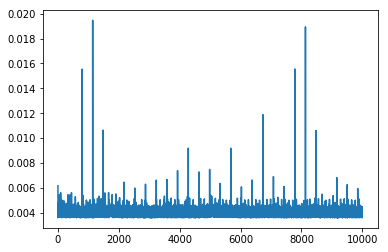

In [135]:
plt.plot(all_locs_1[2])

In [53]:
import matplotlib.pyplot as plt

In [169]:
# for i in range(1000):
#     if len(all_items_1[0][i]) < 2:
#         print(i, len(all_items_1[0][i]))

2 0
5 0
9 1

In [214]:
all_items_1[0][9]

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,date
7274059,2014-12-31 15:00:05+00:00,2014-12-31 15:00:05+00:00,2014-12-31 15:00:05+00:00,a9e9752b26bf9db2,The Advisory Board Company to Present at the 3...,3,1,PRN,"{'CMSS', 'SWIT', 'GEN', 'NEWR', 'BACT', 'COMP'...","{'CNR', 'PRN'}",...,0,0,0,0,0,0,0,0,0,2014-12-31 00:00:00+00:00


In [229]:
c = all_items_1[0][9].values

In [230]:
c[feats[:-1]][:3].values.shape

(1, 18)

In [243]:
arr = c[feats[:-1]][:3].values
rows,col = arr.shape
if rows < 3:
    arr = np.vstack((arr, np.zeros((3-rows, col))))
arr.reshape((-1,1))

In [238]:
np.zeros((3-rows, col)).shape

(2, 18)

In [213]:
# feats = ['sourceId', 'urgency', 'takeSequence', 'provider', 'subjects', 'audiences',
#        'bodySize', 'companyCount', 'marketCommentary',
#        'sentenceCount', 'wordCount', 'assetCodes', 'assetName',
#        'firstMentionSentence', 'relevance', 'sentimentClass',
#        'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
#        'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
#        'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
#        'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
#        'date']
cat = ['sourceId', 'provider', 'subjects', 'audiences',
        'companyCount', 'assetCodes', 'assetName']
feats = ['urgency', 'takeSequence','bodySize', 'companyCount', 'marketCommentary',
         'sentenceCount', 'wordCount','firstMentionSentence', 'relevance', 
         'sentimentClass', 'sentimentNegative', 'sentimentNeutral', 
         'sentimentPositive','sentimentWordCount', 'noveltyCount5D', 
         'noveltyCount7D', 'volumeCounts24H', 'volumeCounts3D', 'month']
all_data['month']=all_data.date.dt.month

In [203]:
import ast
all_subjects = set() 
for i in train_loader.dataset.news.subjects:
    all_subjects.update(ast.literal_eval(i))
    
all_audiences = set() 
for i in train_loader.dataset.news.audiences:
    all_audiences.update(ast.literal_eval(i))

In [200]:
all_data[feats].corrwith(all_data.returnsOpenNextMktres10)

urgency                 0.000728
takeSequence           -0.000410
bodySize               -0.000426
companyCount           -0.000539
sentenceCount          -0.000343
wordCount              -0.000393
firstMentionSentence   -0.000324
relevance              -0.000152
sentimentClass         -0.000139
sentimentNegative      -0.000011
sentimentNeutral       -0.000286
sentimentPositive       0.000279
sentimentWordCount      0.000141
noveltyCount5D         -0.000136
noveltyCount7D         -0.000154
volumeCounts24H         0.000122
volumeCounts3D          0.000179
month                  -0.000937
day                    -0.000949
dtype: float64

In [ ]:
# getting features

In [94]:
np.mean(all_locs[7])

0.004143461608886719

In [157]:
np.sum([np.sum(i) for i in all_locs_2]) # 10

121.30365324020386

In [159]:
np.sum([np.sum(i) for i in all_locs_2]) # 50

119.69122815132141

In [155]:
np.sum([np.sum(i) for i in all_locs_2]) # 100

117.66188406944275

In [153]:
np.sum([np.sum(i) for i in all_locs_2]) # 500

119.10488271713257

In [147]:
np.sum([np.sum(i) for i in all_locs_2]) # 1000

122.02231168746948

In [148]:
np.sum([np.sum(i) for i in all_locs_1[:3]]) # 10000

126.50340414047241

In [58]:
np.mean(locs)

0.004263686585426331

In [59]:
np.sum(locs)

42.636865854263306

In [56]:
np.where(np.array(locs) > 0.05)

(array([1206, 2559, 3910, 5387, 7236, 9586]),)

In [57]:
n_items[1206]

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,date
7265569,2014-12-23 09:13:11+00:00,2014-12-23 09:13:11+00:00,2014-12-23 09:01:15+00:00,d7b12d5b2b2a53be,BRIEF-Phillips 66 reports emissions at Wood Ri...,3,1,RTRS,"{'BLR', 'PROD', 'MOG', 'RTRS', 'REF', 'COM', '...","{'PCO', 'PCU', 'O', 'U', 'RNP', 'OIL', 'CAN', ...",...,0,0,0,0,0,0,0,30,31,2014-12-23 00:00:00+00:00
7267659,2014-12-23 16:34:27+00:00,2014-12-23 16:34:27+00:00,2014-12-23 16:28:58+00:00,085fed63e15d01b8,BRIEF-Phillips 66 says no planned work ongoing...,3,1,RTRS,"{'BLR', 'REF', 'OILG', 'PROD', 'XRNP', 'COM', ...","{'O', 'OIL'}",...,1,1,1,1,1,1,1,9,32,2014-12-23 00:00:00+00:00
7271277,2014-12-29 15:52:10+00:00,2014-12-29 15:52:10+00:00,2014-12-29 15:52:10+00:00,8af22039762d08e2,Phillips 66 says planned work ongoing at Allia...,3,1,RTRS,"{'BLR', 'PROD', 'MOG', 'RTRS', 'REF', 'COM', '...","{'O', 'OIL'}",...,0,0,0,1,0,0,0,0,2,2014-12-29 00:00:00+00:00
7274289,2014-12-31 19:44:35+00:00,2014-12-31 19:44:35+00:00,2014-12-31 19:40:02+00:00,a0cd6c15d70939e8,BRIEF-Phillips 66 reports process upset at its...,3,1,RTRS,"{'BLR', 'PROD', 'INDS', 'MOG', 'RTRS', 'COM', ...","{'O', 'PSC', 'U', 'NAW', 'OIL', 'E'}",...,0,0,0,0,0,0,1,1,1,2014-12-31 00:00:00+00:00
7274619,2015-01-02 02:02:35+00:00,2015-01-02 02:02:35+00:00,2015-01-02 02:02:35+00:00,a84d057cec502bb3,Phillips 66 reports power failure at Wilmingto...,3,1,RTRS,"{'BLR', 'PROD', 'MOG', 'RTRS', 'REF', 'COM', '...","{'O', 'OIL'}",...,0,0,0,0,0,0,1,2,2,2015-01-02 00:00:00+00:00
7274642,2015-01-02 04:16:17+00:00,2015-01-02 04:16:17+00:00,2015-01-02 04:04:28+00:00,c0b84b1922f1f959,BRIEF-Phillips 66 confirms flaring at Wilmingt...,3,1,RTRS,"{'BLR', 'REF', 'OILG', 'PROD', 'XRNP', 'NAMERE...","{'O', 'OIL'}",...,0,0,0,0,1,1,2,3,3,2015-01-02 00:00:00+00:00


In [ ]:
# group saved data in order of companies

In [ ]:
# load saved ranges and look at how you can use it

In [ ]:
"""
features = {urgency: cat, takeseq: cat, provider: cat, subject: bow, bodysize: int
            audiences: bow, marketcom: bool, sentencecount: int, wordcount: int,
            firstmention: int, relevance: int, sentiment: cat [relabel], neg: float,
            neut: float, pos: float}
"""
